# KOH Posterior Analysis using Mici

In [3]:
from models import toymodel as KOHmodel
from data.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

# The data

In [4]:
dataloader = DataLoader('data/toy/field.csv', 'data/toy/sim.csv')
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

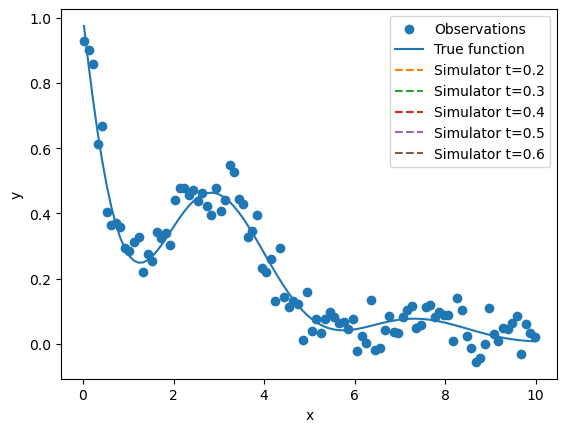

In [5]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4), label='True function')
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    rows = dataloader.tc==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [6]:
theta_0 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 1
lambda_delta_0 = 30
lambda_epsilon_0 = 400
lambda_epsilon_eta_0 = 10000

init_states = np.array([[
    map01toR(theta_0), 
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [7]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [8]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [9]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_warm_up_iter = 200
n_main_iter = 500
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta': state.pos[0], 
        'm_ell_eta_0': state.pos[1], 
        'm_ell_eta_1': state.pos[2],
        'm_ell_delta_0': state.pos[3],
        'm_lambda_eta': state.pos[4],
        'm_lambda_delta': state.pos[5],
        'm_lambda_epsilon': state.pos[6],
        'm_lambda_epsilon_eta': state.pos[7],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [03:08] > Slow adaptive (1/2) [01:54] > Slow adaptive (2/2) [00:44] > Final fast adaptive [00:37] > Main non-adaptive [04:34]

Chain 1/1: 100%|██████████|500/500 [04:34<00:00, 1.82it/s, accept_stat=0.921]

# Analyse MCMC output

In [10]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_theta,0.412,0.151,0.141,0.715,0.009,0.006,370.0,331.0,NaN
m_ell_eta_0,0.785,0.034,0.722,0.843,0.002,0.001,478.0,265.0,NaN
m_ell_eta_1,-1.356,0.047,-1.445,-1.267,0.002,0.001,598.0,387.0,NaN
m_ell_delta_0,0.867,0.315,0.321,1.496,0.016,0.011,411.0,407.0,NaN
m_lambda_eta,-1.378,0.343,-2.015,-0.790,0.019,0.014,340.0,310.0,NaN
m_lambda_delta,3.517,0.303,2.977,4.045,0.014,0.010,457.0,347.0,NaN
m_lambda_epsilon,5.951,0.132,5.701,6.183,0.008,0.005,293.0,306.0,NaN
m_lambda_epsilon_eta,12.207,0.067,12.096,12.344,0.003,0.002,467.0,372.0,NaN
hamiltonian,-2224.102,2.965,-2228.857,-2217.920,0.249,0.176,145.0,230.0,NaN


In [11]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

m_theta :  0.41162877669724185 ± 0.15112779130216258
m_ell_eta_0 :  0.7845183884406008 ± 0.034076191396346184
m_ell_eta_1 :  -1.3560123745136063 ± 0.047100431462602226
m_ell_delta_0 :  0.8670215643854073 ± 0.31428432957821784
m_lambda_eta :  -1.3784772053021925 ± 0.34306680749374757
m_lambda_delta :  3.517225788217528 ± 0.30300517899266477
m_lambda_epsilon :  5.9509391622941115 ± 0.1316248789948177
m_lambda_epsilon_eta :  12.206604134505229 ± 0.06717925125052655
hamiltonian :  -2224.10223388063 ± 2.9621966344328228


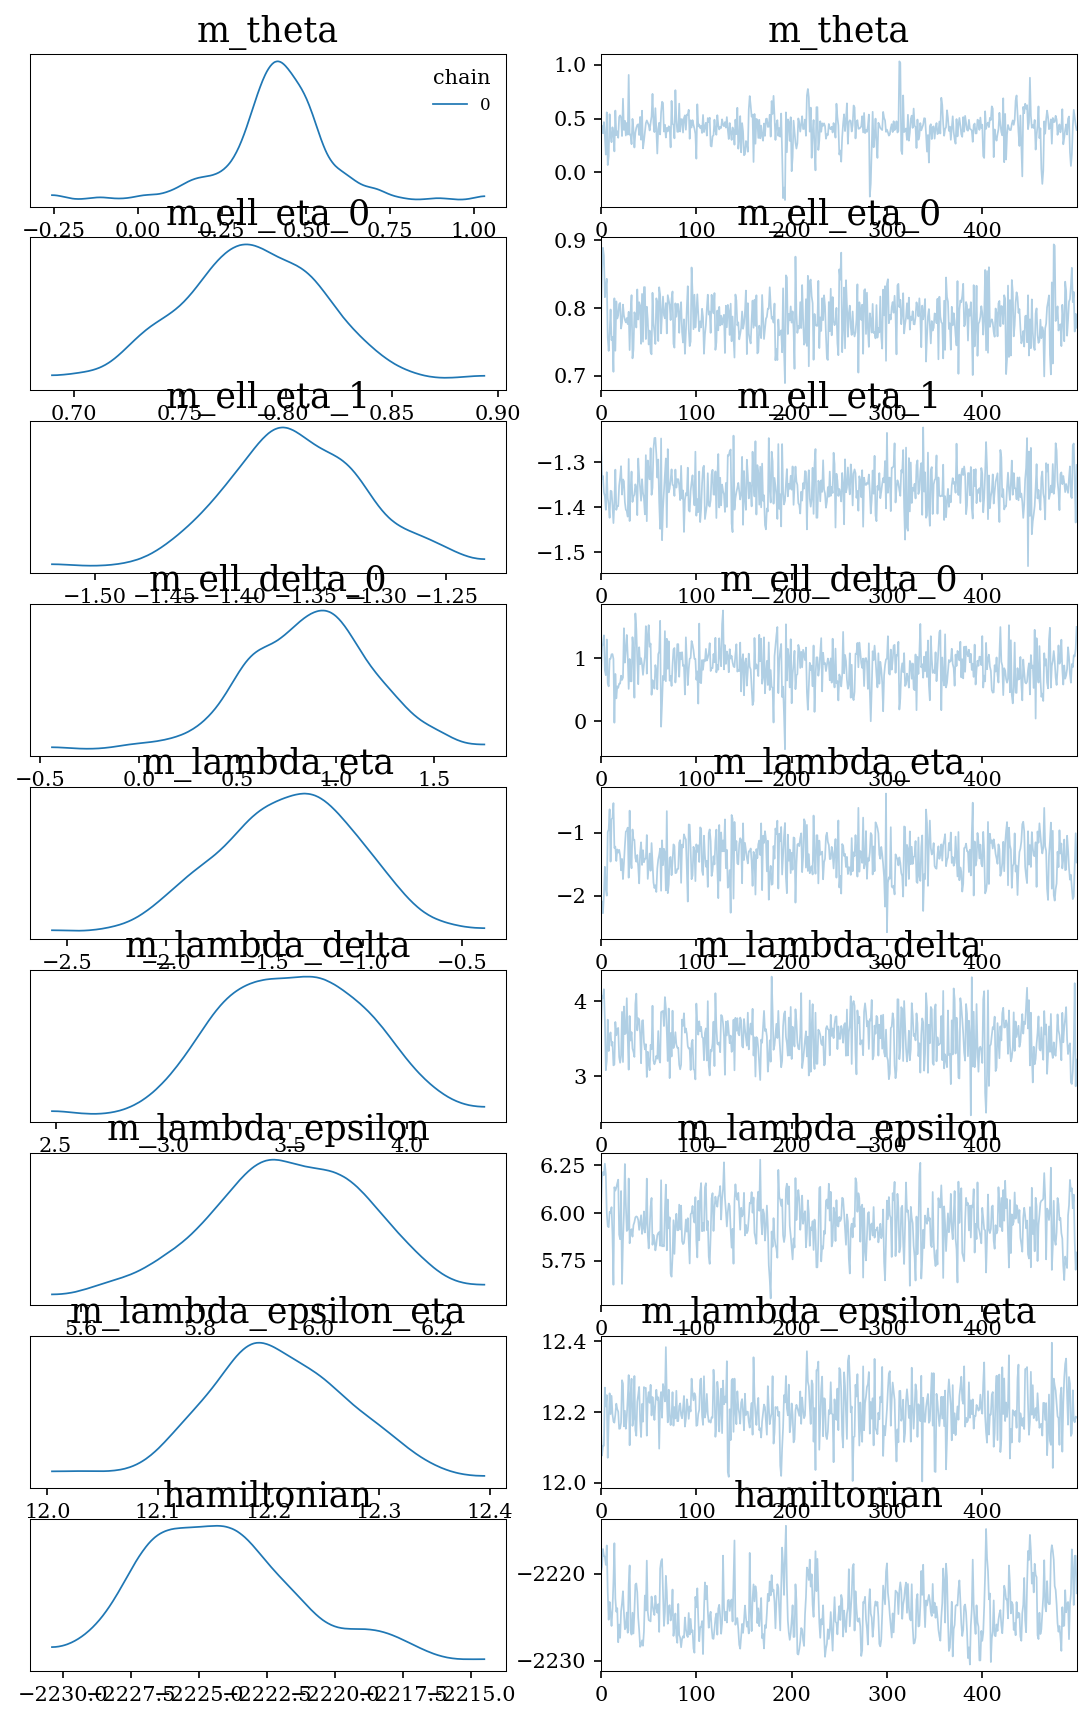

In [12]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [13]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name == 'theta':
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.4084265718452292 ± 0.03417241441902292
ell_eta_0 :  2.1926253095237422 ± 0.07485910003354347
ell_eta_1 :  0.2579727188192766 ± 0.012185264376077224
ell_delta_0 :  2.497705847245891 ± 0.7812764481315638
lambda_eta :  0.2669362524634019 ± 0.09124769576310011
lambda_delta :  35.264982722893706 ± 10.782945251915642
lambda_epsilon :  387.43073910021803 ± 50.602946593494885
lambda_epsilon_eta :  200557.24928994846 ± 13438.998333775382


In [14]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.408,0.034,0.342,0.471,0.002,0.001,370.0,331.0,NaN
ell_eta_0,2.193,0.075,2.059,2.324,0.003,0.003,478.0,265.0,NaN
ell_eta_1,0.258,0.012,0.236,0.282,0.000,0.000,598.0,387.0,NaN
ell_delta_0,2.498,0.782,1.161,3.940,0.038,0.027,411.0,407.0,NaN
lambda_eta,0.267,0.091,0.123,0.435,0.005,0.003,340.0,310.0,NaN
lambda_delta,35.265,10.794,19.324,56.324,0.499,0.354,457.0,347.0,NaN
lambda_epsilon,387.431,50.654,299.079,484.430,2.972,2.118,293.0,306.0,NaN
lambda_epsilon_eta,200557.249,13452.458,179239.757,229617.531,625.920,443.248,467.0,372.0,NaN


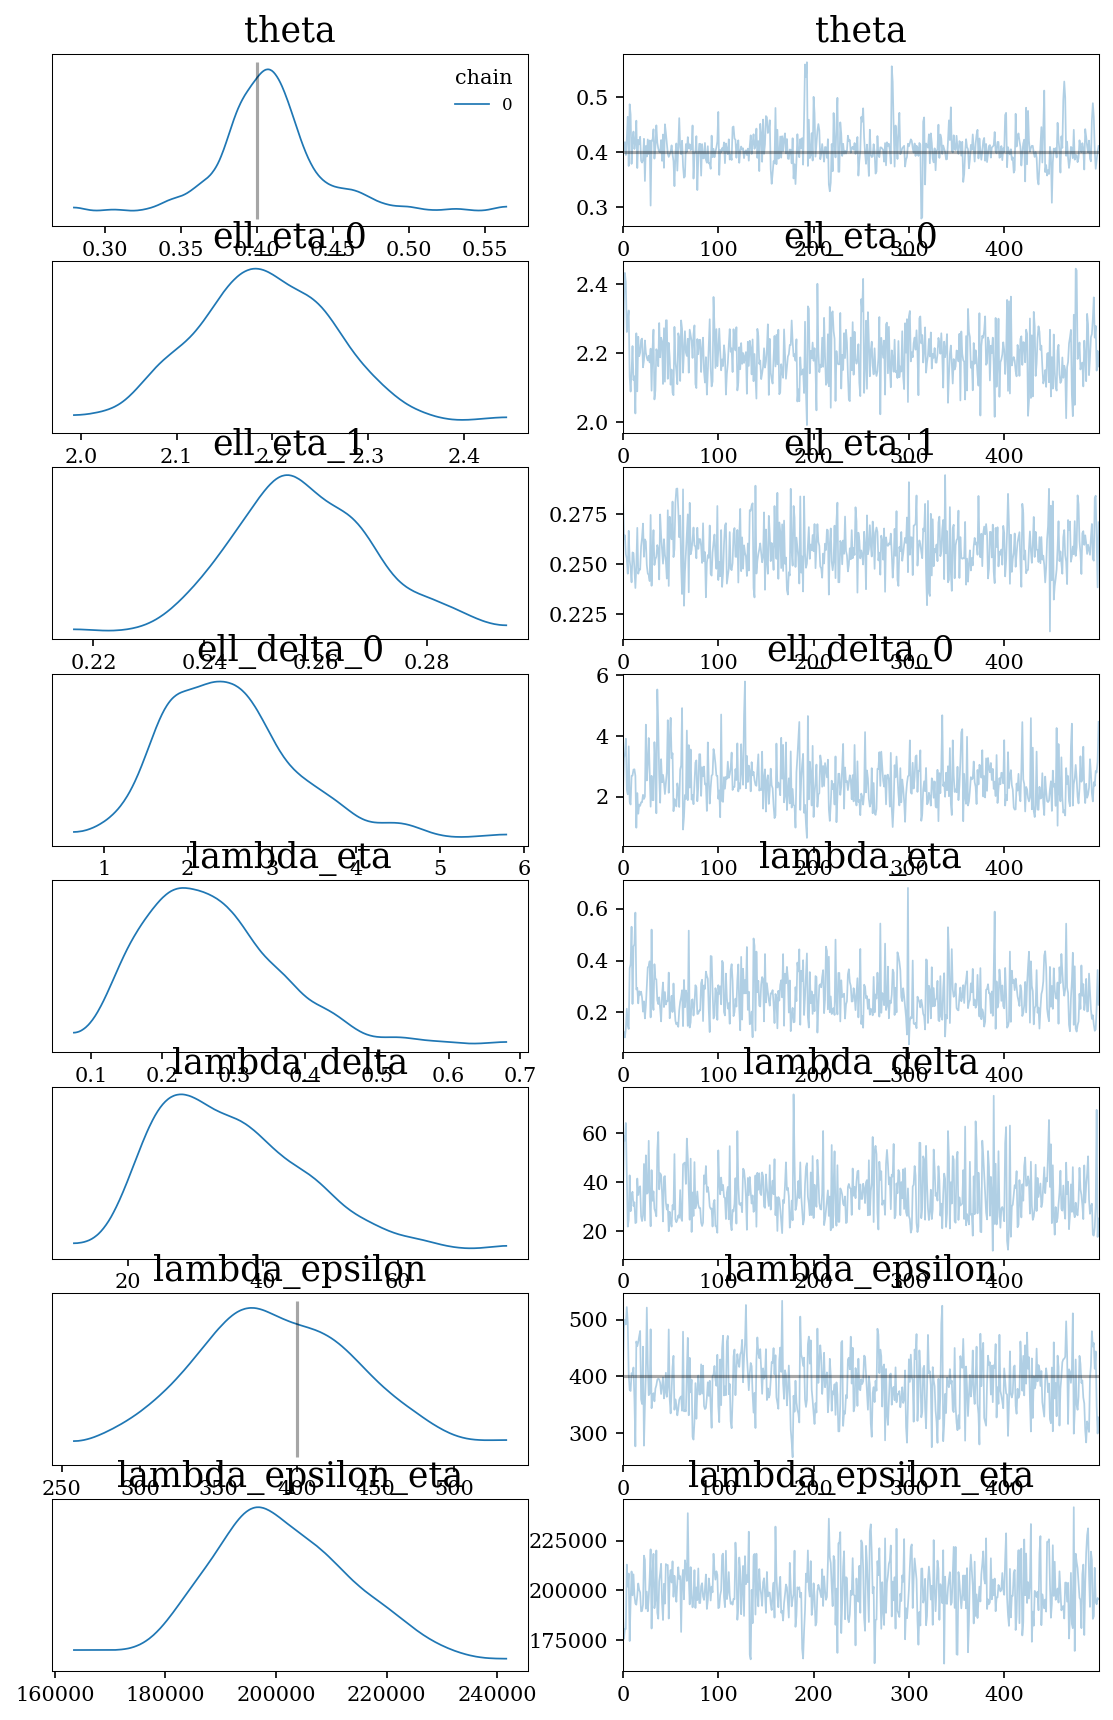

In [15]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [16]:
xpred = np.linspace(0, 10, 1000)

# xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['m_theta'])) # transform theta back to [0, 1]

# x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
# dataset = model.dataset(theta_transformed)
x_test = np.vstack((xpred, theta_transformed*np.ones_like(xpred))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [17]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


# eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
# eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_m = eta_pred.mean() + dataloader.yc_mean
eta_pred_v = eta_pred.variance()
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean() + dataloader.yc_mean
zeta_pred_v = zeta_pred.variance()
zeta_pred_sd = np.sqrt(zeta_pred_v)

# obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
# obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_m = obs_pred.mean() + dataloader.yc_mean
obs_pred_v = obs_pred.variance()
obs_pred_sd = np.sqrt(obs_pred_v)




x = np.linspace(0, 10, 500)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

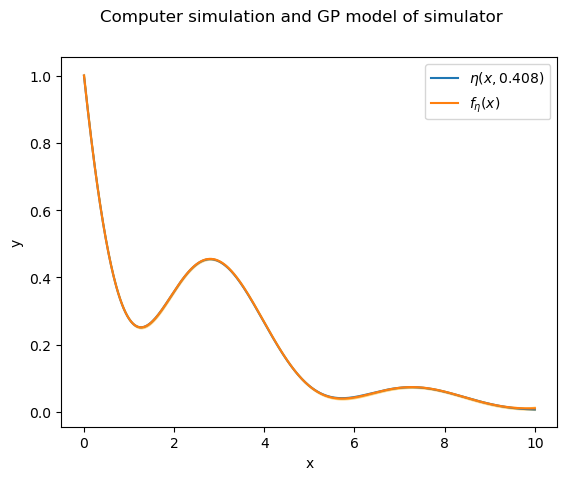

In [18]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, eta(x, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

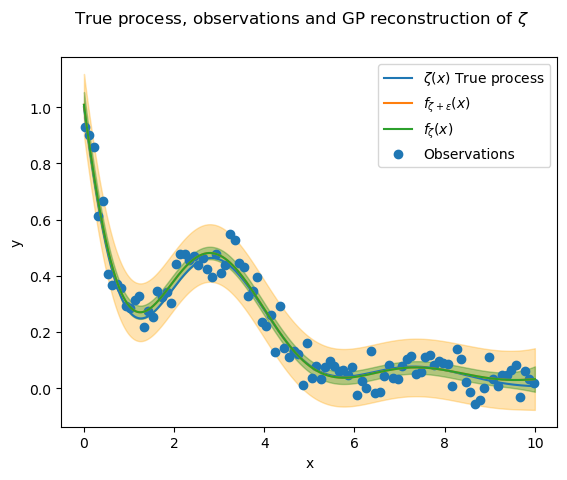

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, zeta(x), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [20]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

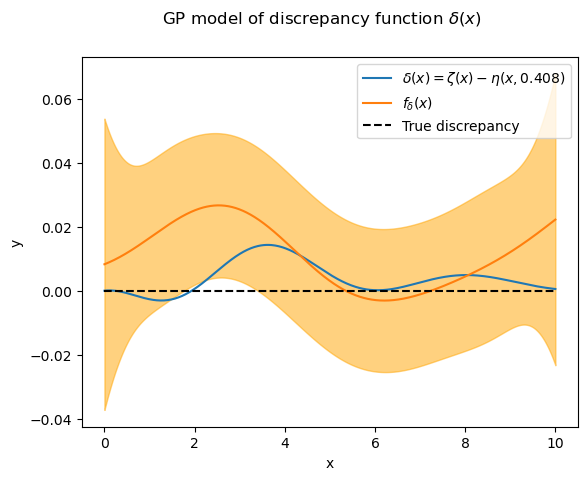

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x) - eta(x, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax.hlines(0, 0, 10, color='black', linestyle='--', label='True discrepancy')

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# The Variance Problem

We assume the following:

\begin{equation}
    Var(z) = Var(\eta) + Var(\delta) + Var(\epsilon) + Var(\epsilon_\eta)
\end{equation}

In [22]:
print(np.var(dataloader.yf))
print(np.var(dataloader.yc))

0.045145746
0.11364993


In [23]:
for t in np.unique(dataloader.tc):
    a = np.var(zeta(dataloader.yc[dataloader.tc==t]))
    print(f"t={t:.3f}: {a:.4f} or 1/{1/a:.3f}")

t=0.031: 0.0681 or 1/14.694
t=0.132: 0.0485 or 1/20.639
t=0.243: 0.0371 or 1/26.988
t=0.311: 0.0361 or 1/27.690
t=0.455: 0.0348 or 1/28.773
t=0.536: 0.0342 or 1/29.252
t=0.635: 0.0339 or 1/29.490
t=0.772: 0.0340 or 1/29.392
t=0.812: 0.0341 or 1/29.319
t=0.977: 0.0345 or 1/28.959


In [24]:
obs_noise = dataloader.yf - zeta(dataloader.xf)
print(np.mean(obs_noise), np.std(obs_noise), 1/np.var(obs_noise))

0.0076009543 0.050806597 387.400127216135


In [25]:
a = 1/params_transformed['lambda_eta']
b = 1/params_transformed['lambda_delta']
c = 1/params_transformed['lambda_epsilon']
d = 1/params_transformed['lambda_epsilon_eta']

print('lambda_eta:', params_transformed['lambda_eta'], f'or 1/{a}')
print('lambda_delta:', params_transformed['lambda_delta'], f'or 1/{b}')
print('lambda_epsilon:', params_transformed['lambda_epsilon'], f'or 1/{c}')
print('lambda_epsilon_eta:', params_transformed['lambda_epsilon_eta'], f'or 1/{d}')

lambda_eta: 0.2669362524634019 or 1/3.7462127784127195
lambda_delta: 35.264982722893706 or 1/0.0283567415262282
lambda_epsilon: 387.43073910021803 or 1/0.0025811065026033636
lambda_epsilon_eta: 200557.24928994846 or 1/4.986107475747665e-06


In [26]:
print(a+b+c+d, 1/(a+b+c+d))

3.7771556125490267 0.26474948415618665


# Correlation decay

In [27]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

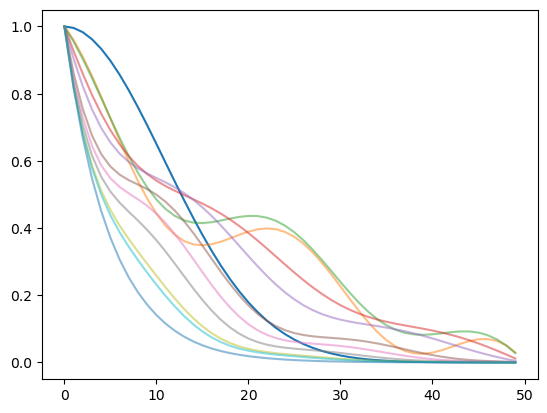

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_data = dataloader.xc[dataloader.tc_normalized==0].reshape(-1, 1)
x_corr = GP_posterior.prior.kernel.k_eta.kernels[0].gram(x_data)[0,:]
x_corr = x_corr/x_corr[0]
ax.plot(x_corr)

for t in np.unique(dataloader.tc):
    y_data = dataloader.yc[dataloader.tc==t]
    y_corr = autocorr(y_data)
    y_corr = y_corr/y_corr[0]
    ax.plot(y_corr, alpha=0.5)

plt.show()